# Stim and position
## Is the direction-location specific stimulation system working correctly?

### Needs emk_neuro_analysis environment
### Loads LFP, camera tracking positions and DIO

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy.stats import circstd

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter

from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

## Experiment parameters

In [2]:
# name of experiment
experiment_name = 'O3'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme0'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220510',]

# choose the epoch - as a list
epoch_list = [5,]

# choose the tetrodes - as a list
tet_list = [28, 27, 20, 19, 17, 16, 15, ]


## Build day records from track confi file and experiment file

In [3]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
# pprint(dict_sessions_all)

In [4]:
# File name format 
# eg. [fname_date]_[fname_exp]_[fname_epoch]_[fname_task].rec
# eg 20211222_clc_02_stim

# Day
fname_date = '20220510'

fname_exp = 'O3'

fname_task = 'stim'

# needs to be a string eg. '04'
fname_epoch = '05' 

# tetrodes to load, a list
tlist = [14, 15, 16, 17, 18, 19, ]
tlist = [15, ]
tlist = [27,]

# directory where your processed file is located
f_datadir = f'/media/{data_disk}/Data/{fname_exp}/preprocessing'

def load_time(data_path):
    return readTrodesExtractedDataFile(data_path)

# load timestamps
dir_time = f'{f_datadir}/{fname_date}/{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.time/'
path_time = f'{dir_time}{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.continuoustime.dat'
dict_time = load_time(path_time)

# convert time to common scale
time_unix_start = int(dict_time.get('system_time_at_creation'))
time_internal_start = int(dict_time.get('timestamp_at_creation'))*-1
time_clockrate = int(dict_time.get('timestamp_at_creation'))

time_data = np.array(list(itertools.chain(*dict_time.get('data'))))

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [7]:
%matplotlib notebook
# get data for each animal

plot_DIO = False

# pump retrigger filter ms
filter_retrigger = 0

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=1)
tick_minutes_fmt = mdates.DateFormatter('%H:%M:%S.%f')
tick_minor = mdates.SecondLocator(interval=1)

dict_sensor_pump_map = {1: {'sensor': 'entrance_sensor'},
                        2: {'pump': 'stim_pump'},
                        6: {'sensor': 'Entrance_sensor'},
                        7: {'sensor': 'Exit_sensor'},
                        9: {'pump': 'reward 1 pump'},
                        }

# list dio
list_dio = [2, 7, 9]
y_label = ['Stim', 
           'Exit', 
           'reward_1'
            ]

# plot each session
# get data for each animal
# initiate output
dict_dio_out = {}
for animal_id in ['O3', ]:
    
    print(animal_id)
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all,
                                        experiment_name, trodes_version=2)
    cls_behavior.filter_animals(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue
        
    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False,
                                               output_raw=False,
                                               filter_retrigger=None)
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False,
                                         output_raw=False,
                                         filter_retrigger=filter_retrigger)
    
    # get unique sessions
    sessions_unique = np.sort(df_sensor['session'].unique())
    print(sessions_unique)
    n_subplots = len(sessions_unique)
    
    if plot_DIO:
        fig = plt.figure(figsize=(10, n_subplots*3+2))
        axs = fig.subplots(n_subplots, 1)
        if n_subplots == 1:
            axs = [axs, ]
            sessions_unique = [sessions_unique[0], ]
            
    else:
        axs = [0]*len(sessions_unique)
        
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):
        # get session times
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        # get sensor and pump times
        df_sensor_curr = df_sensor[df_sensor['session']==session]
        df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start)
                                       & (df_sensor_curr['on_time_sys']<curr_end)]
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start)
                                       & (df_pump_curr['on_time_sys']<curr_end)]
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        
        if not plot_DIO:
            continue
        
        for i, d in enumerate(list_dio):
            #print(d)
            yval = i+1
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]
            # plot well triggers
            
            for ind, row in df_plot_sensor.iterrows():
                ax.scatter(row['on_time_sys'], yval+.3, s=25, c='k')
                
            for ind, row in df_plot_pump.iterrows():
                
                try:
                    ax.plot([row['on_time_sys'],
                              row['off_time_sys']], [yval+.15, yval+.15], c='r')
                
                except:
                    pass

O3
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
['20220510_01' '20220510_02' '20220510_03' '20220510_04' '20220510_05']


## Load position data

In [9]:
# this specifies the zoom factor on the camera
# needs to be measured 
# current setting of L17

cm_pix = {1: 0.3109,
          2: 0.05310,
          3: 0.3109,
          4: 0.05310,
          5: 0.3109,
          6: 0.05310,
          7: 0.3109,
         }

df_pos = pos_iter.iterate_pos_load(dir_preprocess, 
                                   date_list=choose_dates, 
                                   epoch_list=epoch_list, 
                                   cm_pix=cm_pix,
                                   print_debug=False)

4
5
Loaded /media/nvme0/Data/O3/preprocessing/20220510/20220510_O3_05_stim.1.pos
1
2
3


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


## Plot LFP, position, and speed

<IPython.core.display.Javascript object>


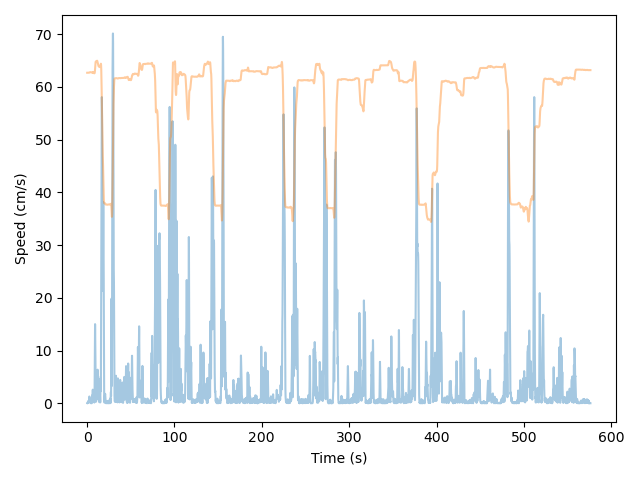

In [10]:
%matplotlib notebook

# sampling rate, convert raw timestamps to seconds on x-axis
fs = 30000

plt.figure()

# speed
plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.dxdydt_cm, zorder=-1, alpha=.4)

# position
# plt.plot(df_pos.time/fs, df_pos.xloc_smooth/10, zorder=-1, alpha=.4)
plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.yloc_smooth/10, zorder=-1, alpha=.4)

plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.tight_layout()

## Stim, position and direction

In [12]:
def replace_with_nearest(lst1, lst2):
    '''
    replace lst1 elements with their nearest elements
    in lst2
    '''
    return lst2[[np.abs(lst2 - e).argmin() for e in lst1]]

def get_timestamp_pos(df, lst):
    '''
    get the positions corresponding to timestamps
    '''
    return np.array([df.loc[df['time']==t, ['xloc_smooth', 'yloc_smooth']].values[0] 
                    for t in lst])

In [13]:
curr_dio = dict_dio_out.get(int(fname_epoch))

stim_timestamp = []
stim_time = []

for ind, row in curr_dio.iterrows():
    
    if row['dio'] == 'laser_pump':
        
        stim_timestamp.append(row['on_time'])
        stim_time.append((row['on_time'] - time_data[0])/30000)

# replace stim timestamps with nearest position timestamps
pos_timestamp = np.array(df_pos.time)
stim_timestamp = replace_with_nearest(stim_timestamp, pos_timestamp)

In [57]:
# cut stim events into trials
stim_pivots = np.where(np.diff(np.append(-19, stim_time)) > 19)[0][1:]
stim_time_cut = np.split(stim_time, stim_pivots)
stim_timestamp_cut = np.split(stim_timestamp, stim_pivots)

In [46]:
reward_1_timestamp = []
reward_1_time = []

for ind, row in df_sensor.iterrows():
    
    if row['dio'] == 'reward_1_sensor':
        
        if (row['off_time']-time_data[0])/fs < 2000:
        
            reward_1_timestamp.append(row['off_time'])
            reward_1_time.append((row['off_time']-time_data[0])/fs)

# replace reward timestamps with nearest position timestamps
reward_1_timestamp = replace_with_nearest(reward_1_timestamp, pos_timestamp)

# cut reward events into trials
reward_pivots = np.where(np.diff(np.append(-40, reward_1_time)) > 40)[0][1:]
reward_1_time_cut = np.split(reward_1_time, reward_pivots)
reward_1_timestamp_cut = np.split(reward_1_timestamp, reward_pivots)

'''
Somehow the last a few chunks could have much larger timestamps than 
pos_timestamp has. Discard them

Sometimes session is broken so no stim chunk follows the last reward
chunk, discard those reward chunks too after visual inspection of the
*_cut arrays

Check the position curve, which is an independent and obvious way of
telling how many trials we have
'''

# curation for 20220510 session 4: huge timestamp chunks at the end, 
# weird reward 1 events in the middle (animal at the opposite reward)
# zone
# reward_1_time_cut = np.delete(reward_1_time_cut[:6], 1, axis=0)
# reward_1_timestamp_cut = np.delete(reward_1_timestamp_cut[:6], 1, axis=0)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in uint_scalars
  


'\nSomehow the last a few chunks could have much larger timestamps than \npos_timestamp has. Discard them\n\nSometimes session is broken so no stim chunk follows the last reward\nchunk, discard those reward chunks too after visual inspection of the\n*_cut arrays\n\nCheck the position curve, which is an independent and obvious way of\ntelling how many trials we have\n'

### inspect trial partition

In [47]:
reward_1_time_cut

[array([19.52033333, 20.556     , 21.10053333, 25.50063333, 27.1235    ,
        27.2711    ]),
 array([91.375     , 91.51033333]),
 array([143.16076667, 146.27953333, 152.91363333, 153.0484    ]),
 array([232.4837]),
 array([281.54226667]),
 array([386.9055    , 387.02083333]),
 array([489.6984    , 493.29053333])]

In [59]:
stim_time_cut

[array([28.71353333, 28.7449    , 28.7942    , 28.87296667, 28.95556667,
        29.0586    , 29.23873333, 29.37246667, 29.54886667, 29.6709    ]),
 array([92.93476667, 92.99396667, 93.14603333, 93.2536    , 93.4304    ,
        93.53226667, 93.6098    , 93.79396667, 93.93713333, 94.1573    ,
        94.21086667, 94.35253333, 94.4151    , 94.53923333, 94.72566667,
        94.867     , 94.9896    , 95.10593333, 95.2327    , 95.3722    ,
        95.41866667, 95.5527    , 95.6866    , 95.79203333, 95.9349    ,
        95.9507    , 95.99386667, 96.09313333]),
 array([154.43913333, 154.4949    , 154.64056667, 154.71936667,
        154.92883333, 155.12106667, 155.17263333, 155.3075    ,
        155.46776667, 155.53033333, 155.69386667]),
 array([233.99396667, 234.11016667, 234.23103333, 234.35613333,
        234.50006667, 234.60326667, 234.71756667, 234.84756667,
        234.99413333, 235.1061    , 235.16933333, 235.32576667,
        235.33596667, 235.4601    , 235.53736667, 235.593     ,
  

### y-position and stim (raw data) across time. identify trials

<IPython.core.display.Javascript object>


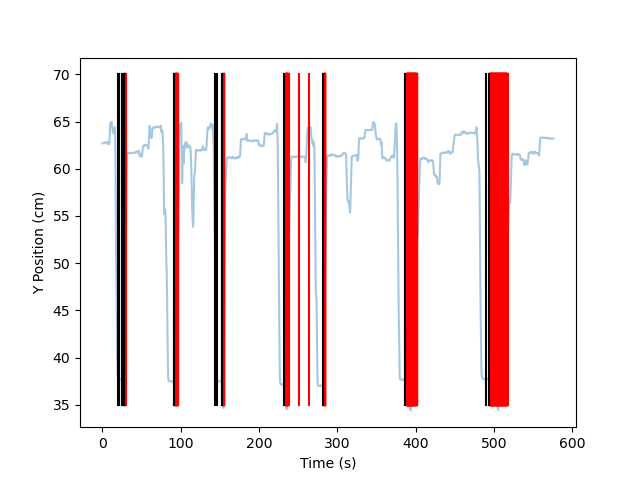

Text(0.5, 0, 'Time (s)')

In [58]:
%matplotlib notebook

# position
plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.yloc_smooth/10, zorder=-1, alpha=.4)

#stims
for st in stim_time:
    plt.plot([st, st], [35, 70], lw=1.5, c='r')

# starting-point reward sensor events
for rt in reward_1_time:
    plt.plot([rt, rt], [35, 70], lw=1.5, c='k')

plt.ylabel('Y Position (cm)')
plt.xlabel('Time (s)')

### x-y spatial distribution of stimulation

<IPython.core.display.Javascript object>


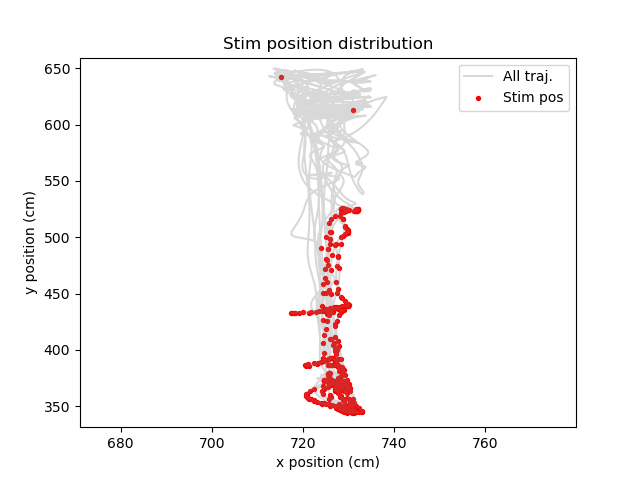

Text(0.5, 1.0, 'Stim position distribution')

In [27]:
%matplotlib notebook

# Position data of ALL stim
stim_pos = get_timestamp_pos(df_pos, stim_timestamp)

# all trajectories across trials
plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3, label='All traj.')
plt.scatter(stim_pos[:,0],stim_pos[:,1], s=8, c='r', alpha=1, label='Stim pos')

plt.legend()
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title('Stim position distribution')

### trial-by-trial stimulation count

<IPython.core.display.Javascript object>


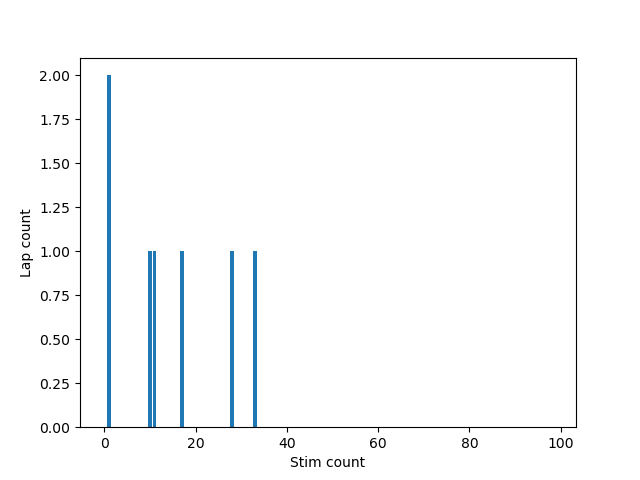

Text(0.5, 0, 'Stim count')

In [28]:
%matplotlib notebook

stim_count_hist, stim_count_edges = np.histogram([len(e) for e in stim_timestamp_cut], range(0,100))

plt.bar(stim_count_edges[:-1],
        stim_count_hist,)

# plt.legend()
plt.ylabel('Lap count')
plt.xlabel('Stim count')

### inspect trajectory and stims in a trial

<IPython.core.display.Javascript object>


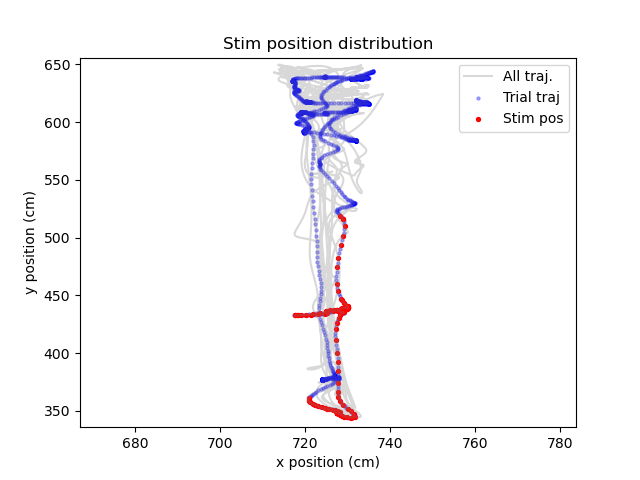

Text(0.5, 1.0, 'Stim position distribution')

In [67]:
# position distribution of stimulation
%matplotlib notebook

trial = 5
    
# Position data for stim in particular trial
stim_pos = get_timestamp_pos(df_pos, stim_timestamp_cut[trial])

# Position data in particular trial
try:
    trial_pos = df_pos.loc[(df_pos['time'] >= reward_1_timestamp_cut[trial][-1]) &
                           (df_pos['time'] <= reward_1_timestamp_cut[trial+1][0]),
                            ['xloc_smooth', 'yloc_smooth']].values

except IndexError:
    trial_pos = df_pos.loc[(df_pos['time'] >= reward_1_timestamp_cut[trial][-1]),
                            ['xloc_smooth', 'yloc_smooth']].values

# all trajectories across trials
plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3, label='All traj.')

plt.scatter(trial_pos[:,0],trial_pos[:,1], s=5, c='b', alpha=.3, label='Trial traj')

plt.scatter(stim_pos[:,0],stim_pos[:,1], s=8, c='r', alpha=1, label='Stim pos')

plt.legend()
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title('Stim position distribution')

In [68]:
# Examine the stims in wrong direction

'''
signed gradient of position; in principle the rat wouldn't go
backwards in the stim zone. Imperfect percentage can be caused
by early tail trigger (then pos gradient < 0) when it turns 
its body around
'''

df_pos_2 = df_pos
df_pos_2['velocity'] = np.gradient(df_pos.get('yloc_smooth'))

stim_post_vel = []
stim_neg_vel = []

for t in stim_timestamp:
    if df_pos.loc[df_pos['time']==t, 'velocity'].values[0] < 0:
        stim_neg_vel.append(t)
    else:
        stim_post_vel.append(t)

print(str(100-len(stim_neg_vel)*100/len(stim_timestamp))
      +"% of the stims have correct directionality")

63.111111111111114% of the stims have correct directionality


<IPython.core.display.Javascript object>


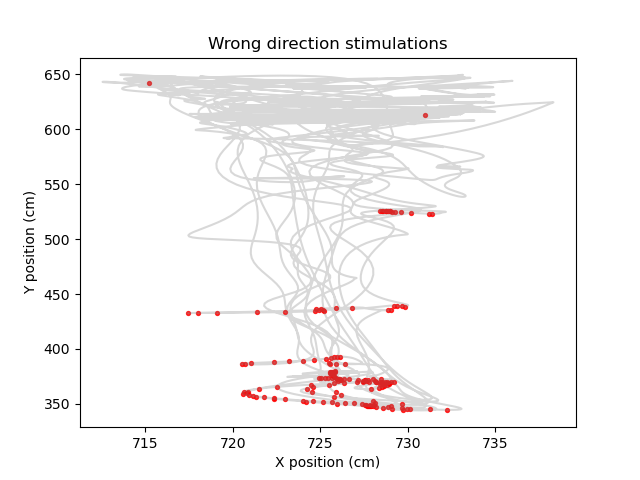

Text(0.5, 1.0, 'Wrong direction stimulations')

In [69]:
%matplotlib notebook

# hypothesis: most (if not all) stims of negative velocity should be in the reward
# zone, cuz those are probably triggered by tail

# cut wrong stims into trials
stim_neg_vel_cut = [[] for i in range(len(stim_timestamp_cut))]

for i in range(len(stim_timestamp_cut)):
    stim_neg_vel_cut[i] = np.array(stim_neg_vel)[np.isin(np.array(stim_neg_vel), 
                                                         stim_timestamp_cut[i])]

plot_all = True
    
trial = 7

if plot_all:
    # all stims of wrong directionality
    stim_neg_pos = get_timestamp_pos(df_pos, stim_neg_vel)

else:
    # stims of wrong directionality in particular trial
    stim_neg_pos = get_timestamp_pos(df_pos, stim_neg_vel_cut[trial]) 

# all trajectories across trials
plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3)

plt.scatter(stim_neg_pos[:,0],stim_neg_pos[:,1], s=8, c='r', alpha=.8)

plt.xlabel('X position (cm)')
plt.ylabel('Y position (cm)')
plt.title('Wrong direction stimulations')

In [135]:
# %matplotlib notebook

# # get the position of rat at a certain amount of delay
# # after departure from reward well

# delay_period = 4 # in secs
# delayed_timestamp = [r[-1][-1]+delay_period*fs for r in reward_1_timestamp_cut]
# delayed_timestamp = replace_with_nearest(delayed_timestamp, pos_timestamp)

# # all trajectories across trials
# plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3)

# # animal's positions at the end of delay period
# delay_pos = get_timestamp_pos(df_pos, delayed_timestamp)

# plt.scatter(delay_pos[:,0],delay_pos[:,1], s=10, c='r', alpha=.8)

# # stims correctly triggered (not by tail) with old logic
# correct_stim_pos = get_timestamp_pos(df_pos, stim_post_vel)

# plt.scatter(correct_stim_pos[:,0],correct_stim_pos[:,1], s=2, c='b', alpha=.5)

# # legend placeholder
# plt.plot([0],[0], c='b', label='Correct stim')
# plt.plot([0],[0], c='r', label='Pos after delay')
# plt.legend()
# plt.xlabel('X position (cm)')
# plt.ylabel('Y position (cm)')
# plt.title('Animal Position after %d sec delay' % delay_period)